In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from pprint import pprint


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


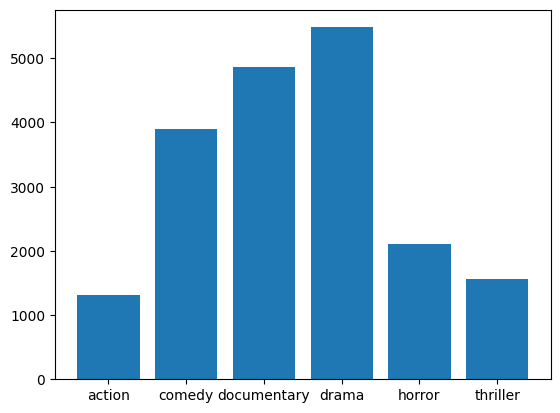

In [77]:
# Part 1.a
genres = ["action", "comedy", "documentary", "drama", "horror", "thriller"]
genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
label_map = {
    "action": 0,
    "comedy": 1,
    "documentary": 2,
    "drama": 3,
    "horror": 4,
    "thriller": 5
}
genre_map = {
    0: "action",
    1: "comedy",
    2: "documentary",
    3: "drama",
    4: "horror",
    5: "thriller"
}
labels = []

train_df = pd.read_csv('data/train.csv', header=0)

labels_df = train_df['genre']

for _, genre in labels_df.items():
    genres_count[genre] += 1
    labels.append(label_map[genre])


plt.bar(genres, genres_count.values())

# weights of each class (for random dataloader later)
weights = []
for count in genres_count.values():
    weights.append((1 - count/len(labels_df))**3)

# validation labels
validation_genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
validation_labels = []

validation_df = pd.read_csv('data/validate.csv', header=0)

validation_labels_df = validation_df['genre']

for _, genre in validation_labels_df.items():
    validation_genres_count[genre] += 1
    validation_labels.append(label_map[genre])

# test data
test_df = pd.read_csv('data/test.csv', header=0, index_col=0)


### Part a writeup
As seen in the plot above, there is a clear imbalance in the data. There are a lot more instances of comedy,
documentary and drama movie types compared to the others

In [84]:
# 1.b
train_df = pd.read_csv('data/train.csv', header=0)

feature_tensor = torch.tensor(train_df.drop(columns=['genre']).values, dtype=torch.double, device=device)
label_tensor = torch.tensor(labels, dtype=torch.long, device=device)

dataset = TensorDataset(feature_tensor, label_tensor)
sample_weights = torch.tensor(weights, device=device)[label_tensor]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True)

dataloader = DataLoader(dataset, 64, sampler=weighted_sampler)

v_feature_tensor = torch.tensor(validation_df.drop(columns=['genre']).values, dtype=torch.double, device=device)
v_label_tensor = torch.tensor(validation_labels, dtype=torch.long, device=device)

t_feature_tensor = torch.tensor(test_df.values, dtype=torch.double, device=device)


### Part b writeup
For the dataloader, I used the built-in Dataloader from Pytorch. The batch size was set to 64 
to allow for faster training. For the sampling, I used a weighted random sampler from Pytorch. 
The weight of each datapoint was calculated by taking the inverse of the total count of the datapoint's
label divided by the total count of all datapoints, all to the power of 3.5 (ie, for datapoint with label "action", it's weight 
is (1 - (# of datapoints with label "action)/(# of total datapoints)))^3.5. The reason for the power of 3.5 is to emphasize the difference between the weights of the majority and minority classes (the value of 3.5 was fount to work the best through trial and error) This random sampling accounts for the uneven distribution of data by putting more weight onto the datapoints with labels that are less present in the dataset. 

*Note, the weights are calculated in the code of part a*

In [65]:
# 1.c
class SimpleNeuralNet(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super().__init__()
        layers = []

        prev_size = 300
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_size, num_nodes, dtype=torch.float64))
            layers.append(nn.ReLU())
            prev_size = num_nodes

        layers.append(nn.Linear(prev_size, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits
    
    def train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_error = 0
            running_sum = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)

            
            # report train and validation loss
            validation_output = self(v_feature_tensor)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(f"EPOCH {i}")
            print(f"Training error: {train_error_list[-1]}")
            print(f"Validation error: {validation_error_list[-1]}")
        
        return train_error_list, validation_error_list  


### Part c writeup
The model is designed to take a number of hidden layers and a number of nodes per hidden layer. Each hidden layer is paired with a ReLU activation function for non-linearities. The model will train for a specified number of epochs, outputting the training and validation accuracy at each epoch.

In [58]:
def get_stats(model, num_epoch):
        
    train_error_list, validation_error_list = model.train(dataloader, 0.001, num_epoch, v_feature_tensor, v_label_tensor)
    epoch_list = [i for i in range(1, num_epoch + 1)]
    plt.figure(1)
    plt.title("Model training error")
    plt.xlabel("Epoch")
    plt.ylabel("Error rate")
    plt.plot(epoch_list, train_error_list)

    plt.figure(2)
    plt.title("Model validation error")
    plt.xlabel("Epoch")
    plt.ylabel("Error rate")
    plt.plot(epoch_list, validation_error_list)

    # accuracy, class-wise and f1 score
    class_accuracy_count = [0] * 6
    accuracy_count = 0
    confusion_matrix = [[0] * 6 for i in range(6)] # row is actual, col is predicted
    class_accuracy_score = []

    for i in range(len(v_feature_tensor)):
        feature = v_feature_tensor[i]
        label = v_label_tensor[i]

        prediction = model(feature)

        if torch.argmax(prediction, 0) == label:
            accuracy_count += 1
            class_accuracy_count[label] += 1

        confusion_matrix[label][torch.argmax(prediction, 0)] += 1

    for class_i in range(6):
        class_accuracy_score.append({
            "TP": 0,
            "TN": 0,
            "FP": 0,
            "FN": 0,
            "AC_rate": 0,
            "F1": 0
        })

        class_accuracy_score[class_i]["TP"] = confusion_matrix[class_i][class_i]

        for row in range(6):
            for col in range(6):
                if row == class_i and col != class_i:
                    class_accuracy_score[class_i]["FN"] += confusion_matrix[row][col]
                if col == class_i and row != class_i:
                    class_accuracy_score[class_i]["FP"] += confusion_matrix[row][col]
                if row != class_i and col != class_i:
                    class_accuracy_score[class_i]["TN"] += confusion_matrix[row][col]

        class_accuracy_score[class_i]["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[genre_map[class_i]]

        r = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) != 0 else 0
        p = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) != 0 else 0
        class_accuracy_score[class_i]["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0

    print(class_accuracy_score)
        


EPOCH 0
Training error: 0.750156044960022
Validation error: 0.604010283946991
EPOCH 1
Training error: 0.6667186617851257
Validation error: 0.5483227372169495
EPOCH 2
Training error: 0.6233873963356018
Validation error: 0.5106908679008484
EPOCH 3
Training error: 0.5926966071128845
Validation error: 0.4720136821269989
EPOCH 4
Training error: 0.5678839087486267
Validation error: 0.49881213903427124
EPOCH 5
Training error: 0.545984148979187
Validation error: 0.4653615951538086
EPOCH 6
Training error: 0.5062422156333923
Validation error: 0.45006176829338074
EPOCH 7
Training error: 0.4836142361164093
Validation error: 0.425829142332077
EPOCH 8
Training error: 0.4762796461582184
Validation error: 0.40739333629608154
EPOCH 9
Training error: 0.4710257947444916
Validation error: 0.41223984956741333
EPOCH 10
Training error: 0.4617665410041809
Validation error: 0.42839494347572327
EPOCH 11
Training error: 0.4646795690059662
Validation error: 0.40121638774871826
EPOCH 12
Training error: 0.450946718

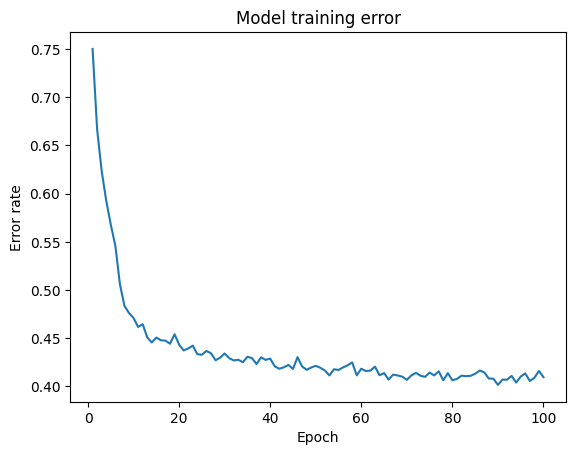

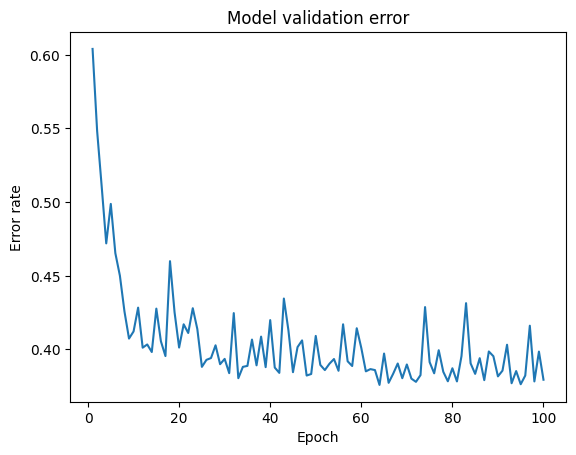

In [79]:
# 1.3 part i)
model = SimpleNeuralNet(1, 64)

model = model.to(device)
    
get_stats(model, 100)


### Part c.i writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 0 | 1432 | 2259 | 1920 | 919 | 0 |
| TN | 9866 | 7323 | 7049 | 6144 | 8512 | 9728 |
| FP | 0 | 959 | 758 | 1367 | 909 | 0 |
| FN | 657 | 809 | 457 | 1092 | 183 | 795 |
| F1 | 0 | 0.62 | 0.79 | 0.61 | 0.63 | 0 |
| Accuracy | 0 | 0.6 | 0.83 | 0.6 | 0.83 | 0 |

Overall Training Accuracy: 0.59

Overall Validation Accuracy: 0.62


EPOCH 0
Training error: 0.7873491048812866
Validation error: 0.7135797739028931
EPOCH 1
Training error: 0.7198293805122375
Validation error: 0.6939085721969604
EPOCH 2
Training error: 0.6415418386459351
Validation error: 0.5060344338417053
EPOCH 3
Training error: 0.6152205467224121
Validation error: 0.5356837511062622
EPOCH 4
Training error: 0.5826570987701416
Validation error: 0.49349045753479004
EPOCH 5
Training error: 0.5781314969062805
Validation error: 0.5135417580604553
EPOCH 6
Training error: 0.5631502270698547
Validation error: 0.4973866939544678
EPOCH 7
Training error: 0.5417186617851257
Validation error: 0.4786657989025116
EPOCH 8
Training error: 0.5411984920501709
Validation error: 0.47191867232322693
EPOCH 9
Training error: 0.5163337588310242
Validation error: 0.45937472581863403
EPOCH 10
Training error: 0.5152413249015808
Validation error: 0.45376795530319214
EPOCH 11
Training error: 0.5117561221122742
Validation error: 0.4491114914417267
EPOCH 12
Training error: 0.5029129

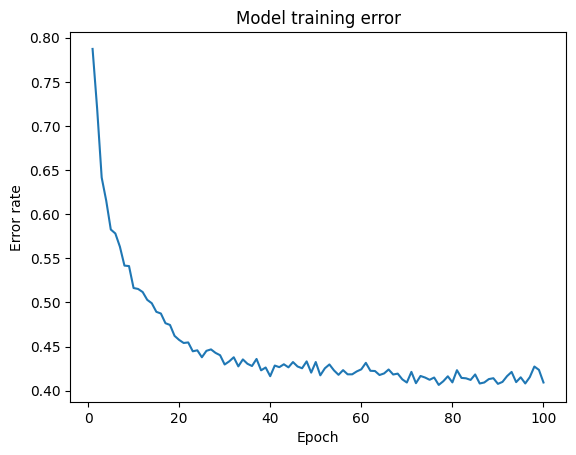

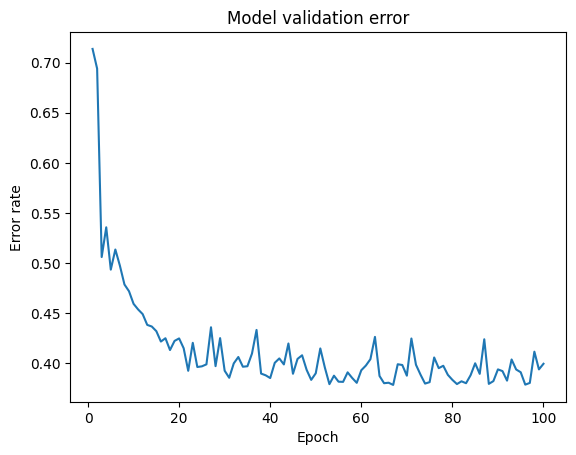

In [80]:
model = SimpleNeuralNet(2, 32)

model = model.to(device)
    
get_stats(model, 100)

### part c.ii writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 6 | 1000 | 2029 | 2335 | 948 | 0 |
| TN | 9843 | 7840 | 7344 | 5314 | 8341 | 9728 |
| FP | 23 | 442 | 463 | 2197 | 1080 | 0 |
| FN | 651 | 1241 | 687 | 677 | 154 | 795 |
| F1 | 0.02 | 0.54 | 0.78 | 0.62 | 0.61 | 0 |
| Accuracy | 0.01 | 0.45 | 0.75 | 0.78 |  0.86 | 0 |

Overall Training Accuracy: 0.59

Overall Validation Accuracy: 0.60

EPOCH 0
Training error: 0.7774136066436768
Validation error: 0.6157940030097961
EPOCH 1
Training error: 0.6695796847343445
Validation error: 0.5457569360733032
EPOCH 2
Training error: 0.6238035559654236
Validation error: 0.5767366886138916
EPOCH 3
Training error: 0.5749063491821289
Validation error: 0.4947258532047272
EPOCH 4
Training error: 0.523980438709259
Validation error: 0.4683075249195099
EPOCH 5
Training error: 0.49256137013435364
Validation error: 0.43903830647468567
EPOCH 6
Training error: 0.4826779067516327
Validation error: 0.4410339295864105
EPOCH 7
Training error: 0.4728464186191559
Validation error: 0.41404542326927185
EPOCH 8
Training error: 0.46296295523643494
Validation error: 0.46232062578201294
EPOCH 9
Training error: 0.4723782539367676
Validation error: 0.5168678164482117
EPOCH 10
Training error: 0.4662921130657196
Validation error: 0.4741993844509125
EPOCH 11
Training error: 0.45505616068840027
Validation error: 0.40359213948249817
EPOCH 12
Training error: 0.45630

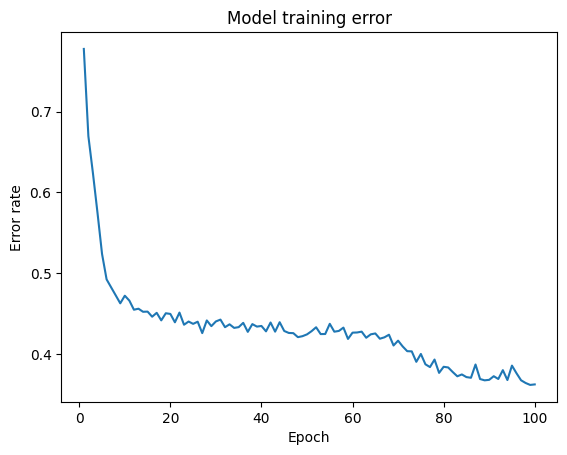

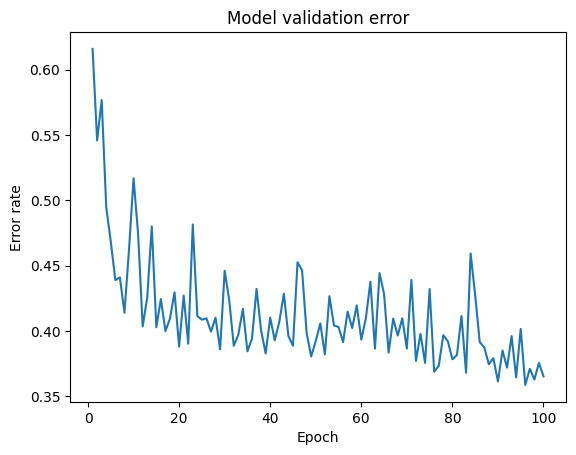

In [81]:
model = SimpleNeuralNet(2, 64)

model = model.to(device)
    
get_stats(model, 100)

### part c.iii writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 285 | 1424 | 1966 | 2105 | 898 | 0 |
| TN | 9659 | 7316 | 7436 | 5907 | 8724 | 9728 |
| FP | 207 | 966 | 371 | 1604 | 697 | 0 |
| FN | 372 | 817 | 750 | 907 | 204 | 795 |
| F1 | 0.50 | 0.61 | 0.79 | 0.63 | 0.67 | 0 |
| Accuracy | 0.43 | 0.64 | 0.72 | 0.70 | 0.81 | 0 |

Overall Training Accuracy: 0.64

Overall Validation Accuracy: 0.64

### part c comparison
The performance of all 3 model architectues are roughly the same, but with the 2 layer, 64 nodes model having the highest test and validation accuracy. This is expected as it has the highest layer and node count of the 3 models, which allows it to capture more about the complex relationship of the input data. Furthermore, 

In [184]:
# 1.d
class GoodNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 512
        self.num_layers = 2

        self.rnn = nn.LSTM(300, self.hidden_size, self.num_layers, batch_first=True, dtype=torch.float64)

        layers = []

        layers.append(nn.Linear(self.hidden_size, 512, dtype=torch.float64))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, 512, dtype=torch.float64)) # Output layer
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.25))
        layers.append(nn.Linear(512, 256, dtype=torch.float64)) # Output layer
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.25))
        layers.append(nn.Linear(256, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float64).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float64).to(x.device)

        out, _ = self.rnn(x, (h0, c0))
        logits = self.stack(out[:, -1, :])
        return logits
    
    def train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_sum = 0
            running_error = 0
            for inputs, label in dataloader:
                inputs = torch.unsqueeze(inputs, 1)
                output = self(inputs) # move channel to first dimension for conv
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)

            # report train and validation loss
            print(f"EPOCH {i}")
            validation_output = self(torch.unsqueeze(v_feature_tensor, 1))
            print(validation_output.shape)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(validation_error_list[-1])

        
        return train_error_list, validation_error_list  

In [186]:
num_epoch = 100
model = GoodNeuralNet()

model = model.to(device)
    
train_error_list, validation_error_list = model.train(dataloader, 0.005, num_epoch, v_feature_tensor, v_label_tensor)
epoch_list = [i for i in range(1, num_epoch + 1)]
plt.figure(1)
plt.plot(epoch_list, train_error_list)
plt.figure(2)
plt.plot(epoch_list, validation_error_list)

# accuracy, class-wise and f1 score
class_accuracy_count = [0] * 6
accuracy_count = 0
confusion_matrix = [[0] * 6 for i in range(6)] # row is actual, col is predicted
class_accuracy_score = []

for i in range(len(v_feature_tensor)):
    label = v_label_tensor[i]
    prediction = model(torch.unsqueeze(torch.unsqueeze(v_feature_tensor[i], 0), 0))
    if torch.argmax(prediction[0], 0) == label:
        accuracy_count += 1
        class_accuracy_count[label] += 1

    confusion_matrix[label][torch.argmax(prediction[0], 0)] += 1
    
for class_i in range(6):
    class_accuracy_score.append({
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0,
        "AC_rate": 0,
        "F1": 0
    })

    class_accuracy_score[class_i]["TP"] = confusion_matrix[class_i][class_i]

    for row in range(6):
        for col in range(6):
            if row == class_i and col != class_i:
                class_accuracy_score[class_i]["FN"] += confusion_matrix[row][col]
            if col == class_i and row != class_i:
                class_accuracy_score[class_i]["FP"] += confusion_matrix[row][col]
            if row != class_i and col != class_i:
                class_accuracy_score[class_i]["TN"] += confusion_matrix[row][col]

    class_accuracy_score[class_i]["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[genre_map[class_i]]

    r = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) != 0 else 0
    p = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) != 0 else 0
    class_accuracy_score[class_i]["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0

print(class_accuracy_score)

EPOCH 0
torch.Size([10523, 6])
tensor(0.7138)


KeyboardInterrupt: 

In [180]:
prediction = model(torch.unsqueeze(t_feature_tensor, 1))

prediction_index = torch.argmax(torch.squeeze(prediction, 1), -1).cpu()

prediction_index = torch.add(prediction_index, 1)
print(prediction_index)

prediction_np = prediction_index.numpy()
prediction_df = pd.DataFrame(prediction_np)
print(prediction_df)
prediction_df.to_csv("submission.csv", index=True, header=["label"])



tensor([5, 3, 3,  ..., 2, 2, 4])
       0
0      5
1      3
2      3
3      3
4      4
...   ..
10518  5
10519  2
10520  2
10521  2
10522  4

[10523 rows x 1 columns]
